In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [61]:
# this should prevent floating point error
def random_spins(n):
  spins = np.random.randint(2, size = (n,n), dtype=np.byte) # random 0 or 1
  return np.where(spins, 1, -1) # the zeroes will evalute to false and become -1

random_spins(5)

array([[ 1, -1,  1,  1, -1],
       [-1, -1,  1, -1, -1],
       [ 1,  1, -1, -1,  1],
       [-1, -1,  1,  1, -1],
       [ 1, -1, -1,  1,  1]])

###**Eliminate the inner loop from the Ising model**

For any location (i,j), the purpose of the inner loop is to locate four neighbors (i+1,j), (i-1,j), (i,j+1), (i,j-1), allowing for wrap-around in the cases where the coordinates overflow or underflow the dimensions of the matrix.

To eliminate the inner loop, for each location (i,j), precompute the four neighbors (represented as 1's in a 20x20 mask of 0's).

During simulation, use these precomputed masks to allows multiplication+addition to calculate change in energy.

In [62]:
mask = np.zeros((N,N,N,N), dtype=np.byte) # create a NxN mask for each coordinate pair (i,j) i<N, j<N
mask.shape

(20, 20, 20, 20)

In [63]:
for i in range(N):
  for j in range(N):
    mask[i,j,i-1,j] = 1 # underflow is automatic because numpy understands [-1] to be the far end of row or col
    mask[i,j,i,j-1] = 1
    mask[i,j,i+1 if i<N-1 else 0,j] = 1 # account for overflow
    mask[i,j,i,j+1 if j<N-1 else 0] = 1

In [50]:
mask[4,4] # sample mask for location 4,4

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [51]:
mask[0,0] # note the effect of underflow

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [64]:
STEPS = 1_000_000
N = 20
J = 1
KB = 1
T = 2

#functionalized version of code presented in the MCMC tutorial
def spins(steps = STEPS, random = True, temp = T, size=N):
  if random:
    lattice_spins = random_spins(size)
  else:
    lattice_spins = np.ones((size,size), dtype=np.byte)

  num_accept = 0
  m_values = []
  for t in tqdm.tqdm(range(steps)):
    i, j = np.random.randint(size), np.random.randint(size)
    # we only need to consider the neighbors of
    # (i, j) to calculate the change in energy
    delta_energy = np.sum(-J * -2 * lattice_spins[i, j] * mask[i, j]) # removed inner loop
    if delta_energy <= 0:
      lattice_spins[i, j] *= -1
      num_accept += 1
    elif delta_energy > 0:
      prob = np.exp(-delta_energy / (KB * temp))
      if np.random.random() < prob:
        lattice_spins[i, j] *= -1
        num_accept += 1
    m_values.append(np.mean(lattice_spins))
  return m_values, lattice_spins, steps

In [65]:
#again, MCMC tout. code packaged into a function
def plot_lattice(lattice_spins):
  plt.figure()
  plt.imshow(lattice_spins, cmap="RdYlBu")
  # show gridlines
  for i in range(N):
      plt.axhline(i + 0.5, color="black", lw=0.1)
      plt.axvline(i + 0.5, color="black", lw=0.1)
  plt.show()

In [66]:
BURNIN = 100_000

#again
def plot_m(m_values, burn_in = BURNIN, temp = T):
  m_mean = np.mean(m_values[burn_in:])
  m_std = np.std(m_values[burn_in:])

  plt.figure()
  plt.plot(range(steps)[:burn_in], m_values[:burn_in], label="Burn in")
  plt.plot(range(steps)[burn_in:], m_values[burn_in:], label="Sampling")
  # show mean as dashed line
  plt.plot(range(steps), m_mean * np.ones((steps)), "--", color="black")
  # show variance as filled box
  plt.fill_between(range(steps), m_mean - m_std, m_mean + m_std, color="gray", alpha=0.3)
  plt.xlabel("Steps")
  plt.ylabel("Magnetization")
  plt.legend(title=f"T={temp}")
  plt.title(f"Burn in = {burn_in}; T = {temp}")
  plt.show()

  print(f"magnetization mean = {m_mean}")
  print(f"magnetization std = {m_std}")

### Problem A, Case 1: All spins up

100%|██████████| 1000000/1000000 [00:38<00:00, 25868.41it/s]


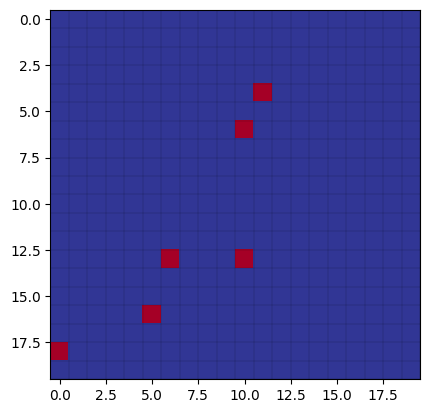

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


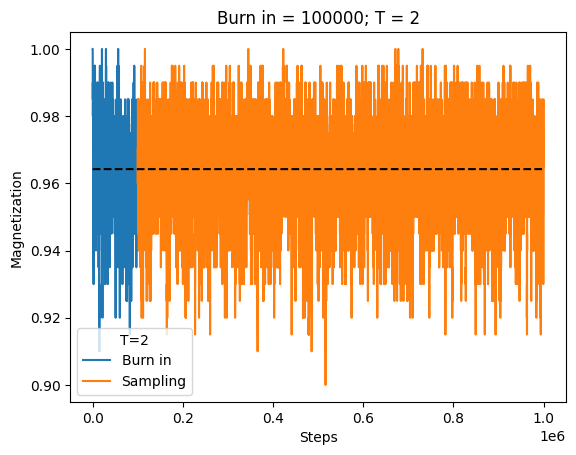

magnetization mean = 0.9642264555555558
magnetization std = 0.013226136418018104


In [67]:
# round MC with all spins up
m_valuesUP, lattice_spins, steps = spins(steps=1_000_000, random=False)
plot_lattice(lattice_spins)
plot_m(m_valuesUP, burn_in = 100_000)

These results do not seem to converge, or do not need any burn in (these cases are indistinguishable). To atempt to distinguish between the possibilties (and therefore understand if my code is working), I must run another test. I will use a much higher tempature, and try to observe convergance.

100%|██████████| 100000/100000 [00:03<00:00, 26509.67it/s]


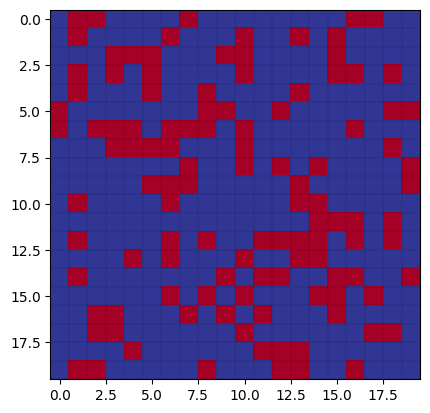

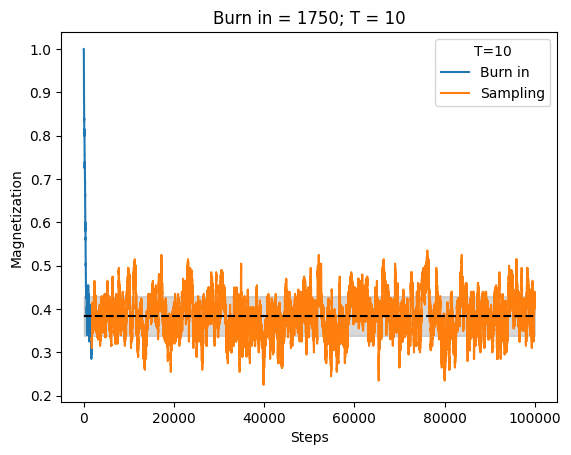

magnetization mean = 0.3839147073791348
magnetization std = 0.04568826501164631


In [68]:
 # test with a high temperture
m_values, lattice_spins, steps = spins(steps=100000, random=False, temp=10)
plot_lattice(lattice_spins)
plot_m(m_values, burn_in=1750, temp=10)

That worked. Not only does it clearly converange, it does so in sevral orders of magnatude fewer itterations.

### Problem A, Case 2: Random initial spins

100%|██████████| 1000000/1000000 [00:34<00:00, 28889.05it/s]


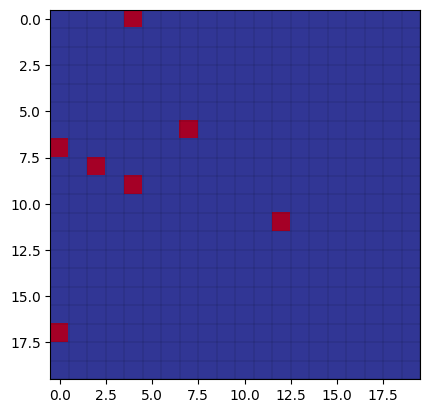

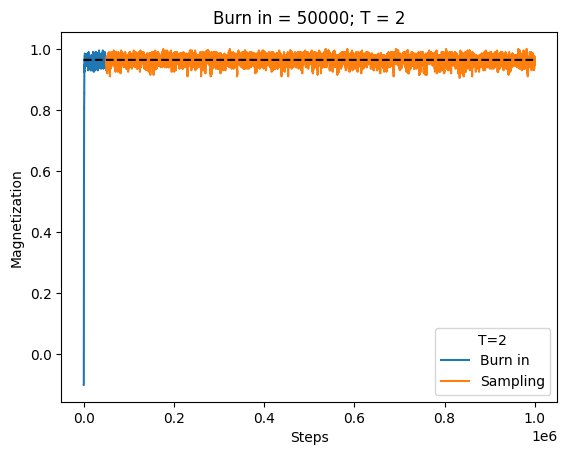

magnetization mean = 0.9641217315789475
magnetization std = 0.013227262013359208


In [69]:
m_valuesRAND, lattice_spins, steps = spins(steps=1_000_000, random=True)
plot_lattice(lattice_spins)
plot_m(m_valuesRAND, burn_in=50_000)

The burn in for the first case is very small, essentually the first time we can consiter our state to be independint from the inital state. I'll use 10% to be safe, but in theory, less would be acceptable. I think as few as 10 000 steps would previde good numbers.

By inspection of the results, I was able to get very simular mean and standard devation with the random start with as few as 50 000 steps in the burn-in. If I were not able compare to the results to the prior method and confirm that they are indeed the same, I would increace the amount of burn-in to increace reliability.

To investagate the number of itterations to get a good magnitazation, lets look at slicing of the mean and standard devation. When these level off to a consistant value, the sample is of adaquate size.  

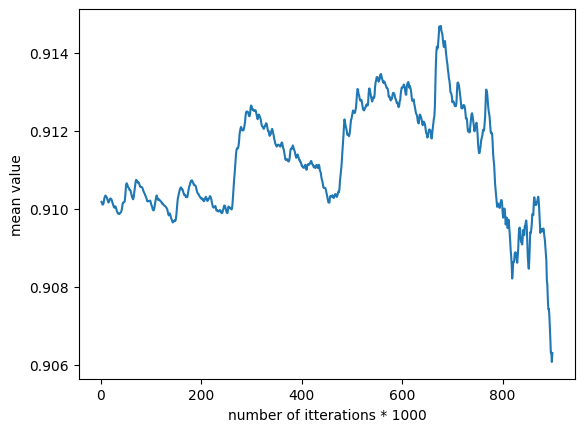

In [ ]:
#slice backwards from the end of the data, being sure to avoid the first 10% (burn-in)
UP_mean = np.array([(x, np.mean(m_valuesUP[:-x*1000])) for x in range(900)])
plt.xlabel('number of itterations * 1000')
plt.ylabel('mean value')
plt.title('spin up initial')
plt.plot(UP_mean.T[0], UP_mean.T[1])

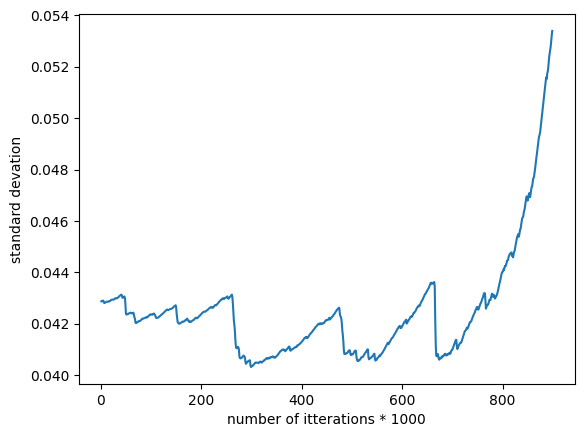

In [ ]:
#same thing, but for the standard devation
UP_std = np.array([(x, np.std(m_valuesUP[:-x*1000])) for x in range(900)])
plt.xlabel('number of itterations * 1000')
plt.ylabel('standard devation')
plt.title('spin up initial')
plt.plot(UP_std.T[0], UP_std.T[1])

At the end of this standard devation graph, we see that I have run into the burn-in (because I am slicing backwards). This shows that my above answer was incorrect, I should use a longer burn-in even though it looks visually settled. Rougly 20% burn-in for the frist run. Also, the standard devation should decreace with a greator number of itterations, so these results look unstable.

I can now do the same for the random inital state (just the standard devation because it is more informative).

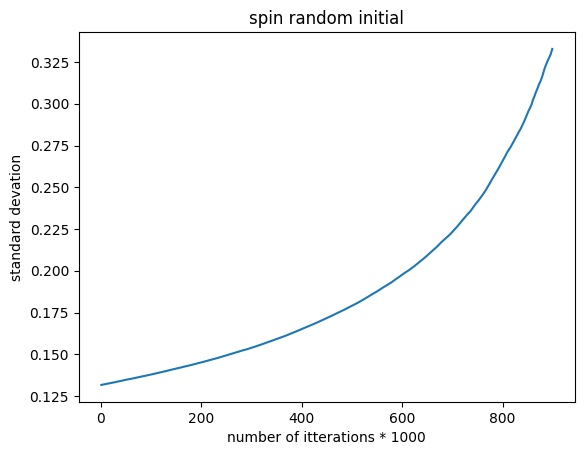

In [ ]:
#same thing, but for the standard devation
RAND_std = np.array([(x, np.std(m_valuesRAND[:-x*1000])) for x in range(900)])
plt.xlabel('number of itterations * 1000')
plt.ylabel('standard devation')
plt.title('spin random initial')
plt.plot(RAND_std.T[0], RAND_std.T[1])

This looks more like I would expect, the standard devation steadaly decreaces with the number of runs. This sugests this method (random inital state) is in some way more stable. Thereofre I will use it in the next part of this question.

A good number of total steps is 900 000 because for the duration of the graph, the results looks stable.

### Problem B

In [ ]:
temps = np.linspace(1,4,16)
temps

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
       3.6, 3.8, 4. ])

In [ ]:
def stats(T, n=1_000_000, burn_in=10000, size=N):
  m_values, _, __ = spins(steps=n, random=False, temp=T, size=N)
  return np.mean(m_values[burn_in:]), np.std(m_values[burn_in:])

In [ ]:
# the initial condition of all spins up is computationally more efficint because it does not need to burn in
results = np.array([stats(temp, n=1_000_000, burn_in=100_000) for temp in temps])

100%|██████████████████████████████| 1000000/1000000 [00:10<00:00, 92043.04it/s]


[]

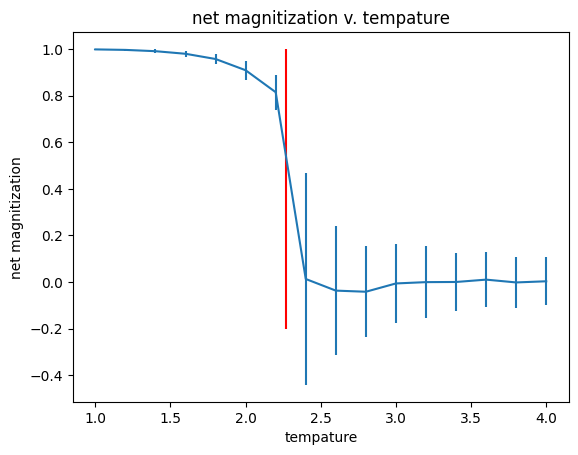

In [ ]:
plt.errorbar(temps, results.T[0], yerr=results.T[1])
plt.vlines([2.269], ymin=-0.2, ymax=1.0, color='red')
plt.title('net magnitization v. tempature')
plt.xlabel('tempature')
plt.ylabel('net magnitization')
plt.plot()

See the bottom of the above section for discussion of burn-in by investigateing the decreace in standard devation vs. number of itterations. I also discuss why the random inital state appears to me to be more stable, this is the reason I chose to use that above. As for other perameters, I had no rigerous reasoning, other than the results looking reasonable to justify my choices. I chose not to use thinning because the results appear to be roughly independent, judgeing by the smootheness of the standard devation curve at the bottom of problem A.